In [1]:
import numpy as np
import matplotlib.pyplot as plt
import MigPreFuncoes
import SlantStack

Imported MigPreFuncoes now
Imported SlantStack now


In [6]:
dx=1
nt=nz=120
ntr=80 
#dt=0.004
dz=dt=1
c=250

#1/250 = 0.004 = dt

In [7]:
np.radians(30)

0.5235987755982988

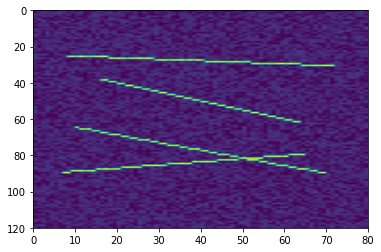

In [8]:
MOD = np.zeros([ntr,nt])

x_ini_1 = int(np.round(1*ntr/5))
x_fim_1 = int(np.round(4*ntr/5))

x_ini_2 = int(np.round(1*ntr/8))
x_fim_2 = int(np.round(7*ntr/8))

x_ini_3 = int(np.round(1*ntr/10))
x_fim_3 = int(np.round(9*ntr/10))

x_ini_4 = int(np.round(1*ntr/11))
x_fim_4 = int(np.round(9*ntr/11))

theta=np.radians(30)
theta2=np.radians(25)
theta3=np.radians(5)
theta4=np.radians(10)
      
for i in range(x_ini_1,x_fim_1):
    z = int(np.round(i*np.sin(theta)) + np.round(nt/4))
    if z < nt:
        MOD[i,z]=1
    
for i in range(x_ini_2,x_fim_2):
    z = int(np.round(i*np.sin(theta2)) + np.round(nt/2))
    if z < nt:
        MOD[i,z]=1
              
for i in range(x_ini_3,x_fim_3):
    z = int(np.round(i*np.sin(theta3)) + np.round(nt/5))
    if z < nt:
        MOD[i,z]=1
              
for i in range(x_ini_4,x_fim_4):
    z = int(np.round(i*np.sin(-theta4)) + np.round(3*nt/4))
    if z < nt:
        MOD[i,z]=1
              

nn = np.random.rand(ntr,nt)
MOD = MOD+(nn-0.5)*0.2

plt.imshow(MOD.T, aspect="auto", extent=[0,dx*ntr,nz*dz,0])
plt.show()

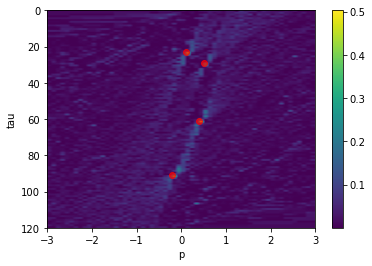

In [9]:
MOD1 = np.zeros([ntr,nt])
MOD2 = np.zeros([ntr,nt])
MOD3 = np.zeros([ntr,nt])
MOD4 = np.zeros([ntr,nt])

for i in range(x_ini_1,x_fim_1):
    z = int(np.round(i*np.sin(theta)) + np.round(nt/4))
    if z < nt:
        MOD1[i,z]=1
    
for i in range(x_ini_2,x_fim_2):
    z = int(np.round(i*np.sin(theta2)) + np.round(nt/2))
    if z < nt:
        MOD2[i,z]=1
              
for i in range(x_ini_3,x_fim_3):
    z = int(np.round(i*np.sin(theta3)) + np.round(nt/5))
    if z < nt:
        MOD3[i,z]=1
              
for i in range(x_ini_4,x_fim_4):
    z = int(np.round(i*np.sin(-theta4)) + np.round(3*nt/4))
    if z < nt:
        MOD4[i,z]=1

    
nn = np.random.rand(ntr,nt)
MOD1 = MOD1+(nn-0.5)*0.2
MOD2 = MOD2+(nn-0.5)*0.2
MOD3 = MOD3+(nn-0.5)*0.2
MOD4 = MOD4+(nn-0.5)*0.2

pmin=-3
pmax=3
dp=0.1

S,pmaxS,taumaxS,smax,ip,itau = SlantStack.slant_stack(pmin,pmax,dp,0,nt*dt,dt,MOD.T,1.0,dt,0,0)
S1,pmaxS1,taumaxS1,smax1,ip1,itau1 = SlantStack.slant_stack(pmin,pmax,dp,0,nt*dt,dt,MOD1.T,1.0,dt,0,0)
S2,pmaxS2,taumaxS2,smax2,ip2,itau2 = SlantStack.slant_stack(pmin,pmax,dp,0,nt*dt,dt,MOD2.T,1.0,dt,0,0)
S3,pmaxS3,taumaxS3,smax3,ip3,itau3 = SlantStack.slant_stack(pmin,pmax,dp,0,nt*dt,dt,MOD3.T,1.0,dt,0,0)
S4,pmaxS4,taumaxS4,smax4,ip4,itau4 = SlantStack.slant_stack(pmin,pmax,dp,0,nt*dt,dt,MOD4.T,1.0,dt,0,0)

plt.imshow(S,extent=[pmin,pmax,nt*dt,0],aspect="auto")
plt.plot(pmaxS1,taumaxS1,'or', alpha=.7)
plt.plot(pmaxS2,taumaxS2,'or', alpha=.7)
plt.plot(pmaxS3,taumaxS3,'or', alpha=.7)
plt.plot(pmaxS4,taumaxS4,'or', alpha=.7)
plt.colorbar()
plt.xlabel('p')
plt.ylabel('tau')
plt.show()

In [10]:
t1 = np.degrees(np.arctan(pmaxS1))
t2 = np.degrees(np.arctan(pmaxS2))
t3 = np.degrees(np.arctan(pmaxS3))
t4 = np.degrees(np.arctan(pmaxS4))

print("pmax MOD1 =", pmaxS1)
print(f"theta 1 = {t1} graus")

print("\npmax MOD2 =", pmaxS2)
print(f"theta 2 = {t2} graus")

print("\npmax MOD3 =", pmaxS3)
print(f"theta 3 = {t3} graus")

print("\npmax MOD4 =", pmaxS4)
print(f"theta 4 = {t4} graus")

pmax MOD1 = 0.5000000000000031
theta 1 = 26.565051177078132 graus

pmax MOD2 = 0.400000000000003
theta 2 = 21.801409486351965 graus

pmax MOD3 = 0.10000000000000275
theta 3 = 5.710593137499799 graus

pmax MOD4 = -0.1999999999999975
theta 4 = -11.309932474020076 graus


**********

### Rodando a Janela

**********

In [9]:
#xwin=twin=25
#m_taumax,m_pmax, s_max = SlantStack.local_window(MOD.T,xwin,twin,dx,dt)

100%|██████████| 120/120 [28:19<00:00, 14.16s/it]


In [10]:
#with open("janela", "wb") as f:
#    np.save(f, m_pmax)

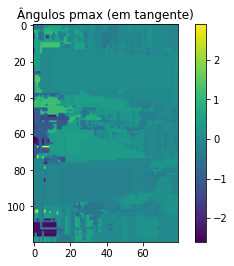

In [11]:
with open("janela", "rb") as f:
    tst = np.load(f)

#plt.figure(figsize=(5,6))
plt.imshow(tst)
plt.title("Ângulos pmax (em tangente)")
plt.colorbar()
plt.show()

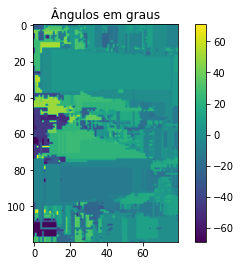

In [12]:
m_theta = np.degrees(np.arctan(tst))
plt.imshow(m_theta)
plt.title("Ângulos em graus")
plt.colorbar()
plt.show()

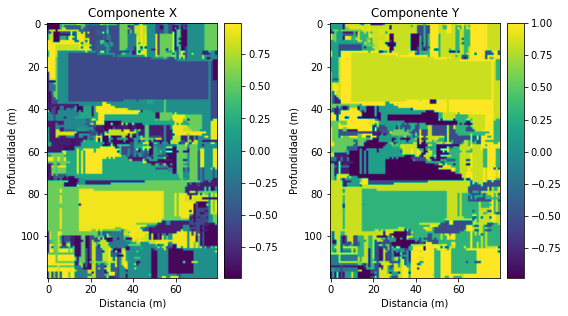

In [13]:
X = np.sin(m_theta)
Y = np.cos(m_theta)

from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(8, 8))

ax1 = fig.add_subplot(121)
ax1.set_title("Componente X")
ax1.set_xlabel("Distancia (m)")
ax1.set_ylabel("Profundidade (m)")
im1 = ax1.imshow(X)
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='10%', pad=0.1)
fig.colorbar(im1, cax=cax, orientation='vertical')


ax2 = fig.add_subplot(122)
ax2.set_title("Componente Y")
ax2.set_xlabel("Distancia (m)")
ax2.set_ylabel("Profundidade (m)")
im2 = ax2.imshow(Y)
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='10%', pad=0.1)
fig.colorbar(im2, cax=cax, orientation='vertical')

plt.tight_layout()
plt.show()

*********

Criando a tabela do tempo de trânsito.

Considerei o dx do nosso modelo como 1 metro. 

Como dt=0.004 s e nt=120, o tempo máximo é 0.48 s

velocidade do modelo c = 120/0.48 = 250 m/s

(120, 80)


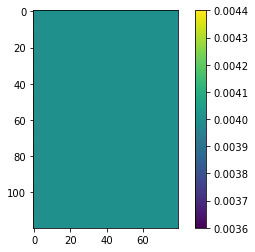

In [14]:
c = 250

SW=np.ones([nt,ntr])*1/c
print(SW.shape)
plt.imshow(SW)
plt.colorbar()
plt.show()

In [15]:
#TT=MigPreFuncoes.raymodel3(SW,dx,ntr,"Data/raiosSlantStack.npy")

In [16]:
with open('Data/raiosSlantStack.npy', 'rb') as f:
    TTh = np.load(f)

print(f"TTh.shape={TTh.shape}")

TTh.shape=(80, 120, 80)


In [17]:
dt=0.004

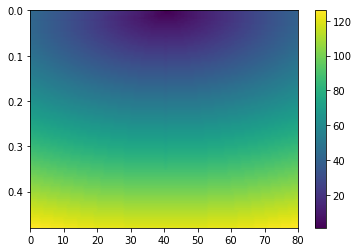

TSX.shape=(120, 80)


In [18]:
TSX = (TTh[40,:,:]/dt+1).astype(int)  # Traveltime  (indexes)
plt.imshow(TSX,extent=[0, ntr*dx, nt*dt, 0], aspect='auto')
plt.colorbar()
plt.show()

print(f"TSX.shape={TSX.shape}")

In [19]:
timer=np.round(TTh/dt)+1

igx = 40
isx = 40

gH = np.gradient(timer, axis=2) #gradiente horizontal
gV = np.gradient(timer, axis=1) #gradiente vertical

prV = gV[igx,:,:] 
prH = gH[igx,:,:] 

psV = gV[isx,:,:] 
psH = gH[isx,:,:] 

pH = psH + prH
pV = psV + prV

In [20]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

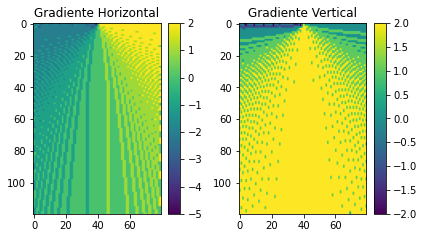

In [21]:
fig = plt.figure(figsize=(6, 6))

ax1 = fig.add_subplot(121)
ax1.set_title("Gradiente Horizontal")
im1 = ax1.imshow(pH)
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='10%', pad=0.1)
fig.colorbar(im1, cax=cax, orientation='vertical')


ax2 = fig.add_subplot(122)
ax2.set_title("Gradiente Vertical")
im2 = ax2.imshow(pV)
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='10%', pad=0.1)
fig.colorbar(im2, cax=cax, orientation='vertical')

plt.tight_layout()

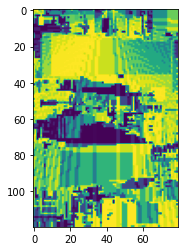

In [22]:
norma = np.sqrt(pH**2 + pV**2)
w = (pH/norma * X) + (pV/norma * Y)

plt.imshow(w)
plt.show()